In [1]:
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath("../../ml/"))

from dev_wtp_io_utils import *

In [2]:
# nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
# ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

sys.path.append(os.path.abspath("../../ml/"))
from apply_loocv_and_save import load_and_preprocess
from dev_utils import read_yaml_for_host
import warnings


config_data = read_yaml_for_host("sst_config.yml")



python initialized for apply_loocv_and_save
cpus available; cpus to use:
10 9
10


In [3]:
nonbids_data_path = config_data['nonbids_data_path']
ml_data_folderpath = nonbids_data_path + "fMRI/ml"


In [4]:
#test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20210601T183243.csv")
#test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20220818T144138.csv")

In [5]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [6]:
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]

In [7]:
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
#2022-01-06 added DEV157 because of an error

In [8]:
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [9]:
def get_Brain_Data_for_sub(sub_label,behavdesign,betaseries_path='/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/'):
    return(dev_wtp_io_utils.get_Brain_Data_betas_for_sub(sub_label,behavdesign,betaseries_path))

In [10]:
from dev_wtp_io_utils import import_sst_betaseries_w1_subjs_to_pkl

In [11]:
all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")
#cut out other waves
sst_1_behavdesign_1 = all_sst_events[(all_sst_events.wave=='wave1')].reset_index(drop=True)
#label the ITI as such
sst_1_behavdesign_1.loc[(all_sst_events.trial_type.isna()),'trial_type']='ITI'
#ensure it is correctly ordered
sst_1_behavdesign_clean = sst_1_behavdesign_1.sort_values(['subject','onset']).reset_index(drop=True)
#now tell it the name of the corresponding beta. this is easy; they are all consecutive
sst_1_behavdesign_clean['beta'] = 'beta_' + (sst_1_behavdesign_clean.groupby(['subject','wave']).cumcount()+1).astype(str).apply(lambda x: x.zfill(4)) + '.nii'

In [12]:
#I want to import this other module; we don't actually use it but it's a good reference
#for future programmers to see
#it's important we keep the logic consistent for the two main conditions
sys.path.append(os.path.abspath("../../fx/multiconds/SST/"))
from multiconds import create_posterror_masks_from_masks

#sst_1_behavdesign_clean['prev_trial_type'] = sst_1_behavdesign_clean['trial_type']
sst_1_behavdesign_clean['prev_trial_type'] = (
    sst_1_behavdesign_clean
    .loc[sst_1_behavdesign_clean['trial_type']!='ITI']
    .groupby(['subject','wave'])
    .shift(1)
    ['trial_type']
)#this works because during assignment, items will be assigned to the line corresponding to their index
#very important you don't reset index during this operation.
is_post_stop_correct_go = (
    (sst_1_behavdesign_clean['trial_type']=='correct-go') & 
    (sst_1_behavdesign_clean['prev_trial_type'].isin(['failed-stop','correct-stop']))
)

sst_1_behavdesign_clean.loc[is_post_stop_correct_go,'post_stop_correct_go_subtype'] = 'Other'
sst_1_behavdesign_clean.loc[is_post_stop_correct_go & (sst_1_behavdesign_clean['prev_trial_type']=='failed-stop'),'post_stop_correct_go_subtype'] = 'post-error'
sst_1_behavdesign_clean.loc[is_post_stop_correct_go & (sst_1_behavdesign_clean['prev_trial_type']=='correct-stop'),'post_stop_correct_go_subtype'] = 'post-correct'


In [13]:
sst_1_behavdesign_clean.groupby(['trial_type','post_stop_correct_go_subtype']).size().reset_index()

,trial_type,post_stop_correct_go_subtype,0
0,correct-go,post-correct,1879
1,correct-go,post-error,2145


In [14]:
sst_1_behavdesign_clean['trial_type'].value_counts()

ITI             26112
correct-go      18750
failed-stop      3434
correct-stop     3094
failed-go         834
Name: trial_type, dtype: int64

In [15]:
behavdesign = sst_1_behavdesign_clean
sst_1_behavdesign_clean_dev005 = behavdesign[[s in 'DEV005' for s in behavdesign.subject]]

## Just subjects in the conditions of interest: CorrectStop vs. CorrectGo

In [16]:
sst_1_behavdesign_clean.trial_type.value_counts()

ITI             26112
correct-go      18750
failed-stop      3434
correct-stop     3094
failed-go         834
Name: trial_type, dtype: int64

In [17]:
sst_1_behavdesign_correct_conditions=sst_1_behavdesign_clean[sst_1_behavdesign_clean.trial_type.isin(['correct-go','correct-stop'])]

In [18]:
sst_1_behavdesign_correct_conditions.trial_type.value_counts()

correct-go      18750
correct-stop     3094
Name: trial_type, dtype: int64

In [19]:
#we have data missing fro mthese subjects below. not enstirely sure yet; see 
#https://docs.google.com/document/d/1EB0ACA6qhMkDEgv-zqNTepPCe_x41fRQHaeqT47vazM/edit#heading=h.60rb13rlxkrq


train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [20]:
sst_1_behavdesign_correct_conditions[sst_1_behavdesign_correct_conditions.subject=='DEV157']

,onset,duration,trial_type,subject,wave,beta,prev_trial_type,post_stop_correct_go_subtype
37376,0.00000,0.87197,correct-go,DEV157,wave1,beta_0001.nii,NaN,NaN
37380,6.38890,0.08329,correct-go,DEV157,wave1,beta_0005.nii,failed-stop,post-error
37384,15.65280,0.59839,correct-go,DEV157,wave1,beta_0009.nii,failed-stop,post-error
37386,20.53475,0.46574,correct-go,DEV157,wave1,beta_0011.nii,correct-go,NaN
37388,23.35212,0.34208,correct-go,DEV157,wave1,beta_0013.nii,correct-go,NaN
...,...,...,...,...,...,...,...,...
37618,400.61111,0.43916,correct-go,DEV157,wave1,beta_0243.nii,correct-go,NaN
37620,404.11667,0.72024,correct-go,DEV157,wave1,beta_0245.nii,correct-go,NaN
37622,407.24723,0.43989,correct-go,DEV157,wave1,beta_0247.nii,correct-go,NaN
37626,412.44516,0.00170,correct-go,DEV157,wave1,beta_0251.nii,failed-stop,post-error


### Now mask those subjects

In [21]:
# get the PFC mask
mask_pfc = nib.load(ml_data_folderpath + '/prefrontal_cortex.nii.gz')

In [22]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:2],'betaseries',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
    mask = mask_pfc,
    out_file_suffix = '_correct_cond',
    sst_wt_repo = nonbids_data_path + "fMRI/fx/models/SST/wave1/")

/Users/benjaminsmith/Google Drive/oregon/data/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/
DEV005
........................................................................................verified that all expected betas exist! Processing...retrieving a mask from the first image in the series beta_0001.nii
...using a combined mask of the first image and the passed in maskDuring mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
converting to nifti and fdata
         onset  duration    trial_type subject   wave           beta  \
256    0.00000   2.25834  correct-stop  DEV005  wave1  beta_0001.nii   
258    2.75834   0.40082    correct-go  DEV005  wave1  beta_0003.nii   
260    5.51390   0.66191    correct-go  DEV005  wave1  beta_0005.nii   
264   12.52780   0.51712    correct-go  DEV005  wave1  beta_0009.nii   
266   15.90975   0.39906    correct-go  D

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/nltools/data/brain_data.py:887: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out.X = self.X.append(data.X, **kwargs)


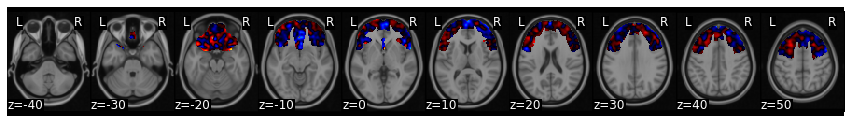

In [24]:
#open pickle file
import pickle
with open('/Users/benjaminsmith/Google Drive/oregon/data/DEV/nonbids_data/fMRI/ml/SST/Brain_Data_betaseries_2subs_correct_cond.pkl', 'rb') as f:
    data = pickle.load(f)


#display data as a Brain_Data file
data[0].plot()